<a href="https://colab.research.google.com/github/bhaveshsingh0206/Contextual-Embedding-based-Stock-Price-Prediction-using-Bidirectional-LSTM/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
!pip install transformers
!pip install gensim
!pip install sns
!pip install torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sns: filename=sns-0.1-py3-none-any.whl size=2662 sha256=c9c25add20fa94b35a136dc53a1494b5158d61ec9efd3dca0ded20179d21aba4
  Stored in directory: /root/.cache/pip/wheels/94/30/68/c7bbc5257894097a14adf5c7d6e7de56127c9936f27afe2416
Successfully built sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [229]:
import pandas as pd
import requests


In [ ]:
text=[]
sentiment=[]
with open('/content/drive/MyDrive/NLP Dataset/FinancialPhraseBank-v1.0 2/Sentences_50Agree.txt', encoding = "ISO-8859-1") as f:
  lines = f.read().splitlines()
  for line in lines:
    line=line.rstrip().split('@')
    text.append(' '.join(line[:-1]))
    sentiment.append(line[-1])

In [ ]:
data = {'Text': text, 'Sentiment': sentiment}  
df = pd.DataFrame(data)  
df.head()

,Text,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [ ]:
df.isna().sum()

Text         0
Sentiment    0
dtype: int64

In [ ]:
df.head()

,Text,Sentiment
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [ ]:
df['Sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [ ]:
from bs4 import BeautifulSoup
import re

In [ ]:
punctuations = '''!()-[]{};:"\,<>./?@#%^&*_~'''
def cleanText(x):
  x = x.lower().strip()
  soup = BeautifulSoup(x)
  x = soup.get_text()
  x = re.sub(r'https?://\S+', '', x)
  x=re.sub("\s\s+", " ", x.strip())
  no_punct = ""
  for char in x:
    if char not in punctuations:
        no_punct = no_punct + char
    else:
        no_punct += " "
  x = no_punct

  x=re.sub("\s\s+", " ", x.strip())
  if (x==' ' or len(x)==0): 
    return np.nan
  return x

In [ ]:
df['Text']= df['Text'].apply(cleanText)
maxLen = 0
for l in df['Text']:
  maxLen = max(maxLen, len(l.split(' ')))
print(maxLen)

73


In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
labels = {'neutral':0,
          'negative':1,
          'positive':2,
          }

In [ ]:
def change_label(x):
  return labels[x]
df['Sentiment_Label']=df['Sentiment'].apply(change_label)

In [ ]:
# /df.head()

,Text,Sentiment,Sentiment_Label
0,according to gran the company has no plans to ...,neutral,0
1,technopolis plans to develop in stages an area...,neutral,0
2,the international electronic industry company ...,negative,1
3,with the new production plant the company woul...,positive,2
4,according to the company 's updated strategy f...,positive,2


In [ ]:
labels = {'neutral':0,
          'negative':1,
          'positive':2,
          }
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['Sentiment']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                            return_tensors="pt") for text in df['Text']]
    def classes(self):
        return self.labels
    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.9*len(df))])

print(len(df_train),len(df_val))

4361 485


In [ ]:
df_train.head()

,Text,Sentiment,Sentiment_Label
3207,the company was supposed to deliver machinery ...,neutral,0
1684,unc charlotte would also deploy ssh tectia con...,neutral,0
1044,in 2009 lee man had a combined annual producti...,neutral,0
4145,`` that 's a very high figure on the european ...,neutral,0
1538,in finland the corresponding service is alma m...,neutral,0


In [ ]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        # print(input_id.shape)
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        # print(dropout_output.shape)
        linear_output = self.linear(dropout_output)
        # print(linear_output.shape)
        final_layer = self.relu(linear_output)
        # print(final_layer.shape)
        return final_layer
    
    def get_vector(self, input_id, mask):
      _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask, return_dict=False)
      dropout_output = self.dropout(pooled_output)
      return dropout_output

In [ ]:
# batch, max_seq_len, dimension

In [ ]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                batch_loss = criterion(output, train_label.long())
                # break
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            # break
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  

In [ ]:
EPOCHS = 5
bert_pretrained_model = BertClassifier()                        
LR = 1e-6                                                                                                                       
train(bert_pretrained_model, df_train, df_val, LR, EPOCHS)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2181/2181 [07:53<00:00,  4.61it/s]


Epochs: 1 | Train Loss:  0.458                 | Train Accuracy:  0.593                 | Val Loss:  0.392                 | Val Accuracy:  0.660


100%|██████████| 2181/2181 [08:06<00:00,  4.49it/s]


Epochs: 2 | Train Loss:  0.341                 | Train Accuracy:  0.715                 | Val Loss:  0.342                 | Val Accuracy:  0.709


100%|██████████| 2181/2181 [08:05<00:00,  4.49it/s]


Epochs: 3 | Train Loss:  0.261                 | Train Accuracy:  0.787                 | Val Loss:  0.299                 | Val Accuracy:  0.730


100%|██████████| 2181/2181 [08:05<00:00,  4.49it/s]


Epochs: 4 | Train Loss:  0.167                 | Train Accuracy:  0.893                 | Val Loss:  0.225                 | Val Accuracy:  0.843


100%|██████████| 2181/2181 [08:05<00:00,  4.49it/s]


Epochs: 5 | Train Loss:  0.100                 | Train Accuracy:  0.948                 | Val Loss:  0.228                 | Val Accuracy:  0.839


In [ ]:
# Save Bert Model
# torch.save(bert_pretrained_model.state_dict(), '/content/drive/MyDrive/NLP Dataset/model/bert_pretrained_model.pt')
bert_pretrained_model = BertClassifier()
bert_pretrained_model.load_state_dict(torch.load('/content/drive/MyDrive/NLP Dataset/model/bert_pretrained_model.pt'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [230]:
from torch.optim import Adam
import torch
import random
import torch.nn as nn
import torch.nn.functional as F

class GRUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=True, dropout=0.2)   
        self.linear = nn.Linear(self.hidden_dim*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(64, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        h_lstm, _ = self.gru(x, hidden)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out
    
    def get_vector(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        h_lstm, _ = self.gru(x, hidden)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.linear(conc)
        conc = self.dropout(conc)
        return conc
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers*2, batch_size, self.hidden_dim)
        return hidden.to(device)

In [ ]:
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=True, dropout=0.2)   
        self.linear = nn.Linear(self.hidden_dim*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(64, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)
        hidden, c = self.init_hidden(batch_size)
        h_lstm, _ = self.lstm(x, (hidden, c))
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out
    
    def get_vector(self, x):
        batch_size = x.size(0)
        hidden, c = self.init_hidden(batch_size)
        h_lstm, _ = self.lstm(x, (hidden, c))
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.linear(conc)
        conc = self.dropout(conc)
        return conc
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers*2, batch_size, self.hidden_dim)
        c = torch.zeros(self.n_layers*2, batch_size, self.hidden_dim)
        return hidden.to(device), c.to(device)

In [ ]:
import gensim.downloader as api
model = api.load("word2vec-google-news-300")
word2Vec = model

In [ ]:
'Sunday' in word2Vec.wv.vocab

<ipython-input-28-1916363e0792>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  'Sunday' in word2Vec.wv.vocab


True

In [ ]:
XSentences = []
import math
for i, sent in enumerate(df['Text'].tolist()):
    sent = sent.split(' ')
    temp = []
    for word in sent:
        if word in word2Vec.wv.vocab:
            temp.append(word2Vec[word])
    if(len(temp)==0):
        temp.append(np.zeros(300))
    XSentences.append(temp)

<ipython-input-110-abbdbc1b4582>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in word2Vec.wv.vocab:


In [ ]:
print(len(XSentences))

4846


In [ ]:
def createXForRNN(l, XSentences):
    X = np.zeros([len(XSentences), l, 300])
    for i, sent in enumerate(XSentences):
        for j in range(0, l):
            if(j<len(sent)):
                word = sent[j]
                temp=word
            else:
                temp = np.zeros(300)

            X[i][j] = temp
    return X
X_rnn = createXForRNN(maxLen, XSentences)
print(X_rnn.shape)

(4846, 73, 300)


In [ ]:
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 2
def createDataLoader(X_train, Y_train, X_test, Y_test):
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
  Y_train = torch.tensor(Y_train,  dtype=torch.long).to(device)
  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
  Y_test = torch.tensor(Y_test,  dtype=torch.long).to(device)
  train = torch.utils.data.TensorDataset(X_train, Y_train)
  test = torch.utils.data.TensorDataset(X_test, Y_test)

  train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
  return train_loader, test_loader

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_rnn, np.array(df['Sentiment_Label'].tolist()), test_size=0.1, random_state=42)
train_loader, test_loader = createDataLoader(X_train, Y_train, X_test, Y_test)
import time
def evaluate(n_epochs, model, optimizer, train_loader, test_loader, criterion):
    def calculateCorrect(t, y):
        sum=0
        for i, v in enumerate(t):
            if(t[i]==y[i]):
                sum+=1
        return sum

    for e in tqdm(range(n_epochs)):
        start_time = time.time()
        model.train()
        avg_loss = 0.  
        for i, (x, y) in enumerate(train_loader):
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
      
        model.eval()        
        avg_val_loss = 0.
        val_preds = np.zeros((len(X_test), 3))
      
        for i, (x_batch, y_batch) in enumerate(test_loader):
            y_pred = model(x_batch).detach()
            avg_val_loss += criterion(y_pred, y_batch).item() / len(test_loader)
            val_preds[i * BATCH_SIZE:(i+1) * BATCH_SIZE] = F.softmax(y_pred).cpu().numpy()
          
        accuracy = calculateCorrect(val_preds.argmax(axis=1), Y_test)/len(Y_test)
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t loss={:.4f} \t test_loss={:.4f}  \t test_acc={:.4f}  \t time={:.2f}s'.format(
                  e + 1, n_epochs, avg_loss, avg_val_loss, accuracy, elapsed_time))

In [ ]:
from torch.optim import Adam
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = LSTMModel(300, 3, 20, 2)
optimizer_rnn = Adam(model1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model1.to(device)

evaluate(20, model1, optimizer_rnn, train_loader, test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-73-146d243415a7>:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * BATCH_SIZE:(i+1) * BATCH_SIZE] = F.softmax(y_pred).cpu().numpy()
  5%|▌         | 1/20 [00:10<03:11, 10.08s/it]

Epoch 1/20 	 loss=0.7662 	 test_loss=0.6376  	 test_acc=0.7588  	 time=10.08s


 10%|█         | 2/20 [00:20<03:07, 10.42s/it]

Epoch 2/20 	 loss=0.5031 	 test_loss=0.4593  	 test_acc=0.8124  	 time=10.66s


 15%|█▌        | 3/20 [00:29<02:46,  9.82s/it]

Epoch 3/20 	 loss=0.4009 	 test_loss=0.4289  	 test_acc=0.8206  	 time=9.10s


 20%|██        | 4/20 [00:38<02:32,  9.52s/it]

Epoch 4/20 	 loss=0.3415 	 test_loss=0.4366  	 test_acc=0.8227  	 time=9.05s


 25%|██▌       | 5/20 [00:48<02:20,  9.39s/it]

Epoch 5/20 	 loss=0.2903 	 test_loss=0.5252  	 test_acc=0.7856  	 time=9.17s


 30%|███       | 6/20 [00:57<02:11,  9.37s/it]

Epoch 6/20 	 loss=0.2432 	 test_loss=0.5005  	 test_acc=0.8144  	 time=9.34s


 35%|███▌      | 7/20 [01:06<02:02,  9.45s/it]

Epoch 7/20 	 loss=0.1989 	 test_loss=0.5839  	 test_acc=0.8289  	 time=9.59s


 40%|████      | 8/20 [01:16<01:52,  9.40s/it]

Epoch 8/20 	 loss=0.1638 	 test_loss=0.5519  	 test_acc=0.8412  	 time=9.29s


 45%|████▌     | 9/20 [01:25<01:42,  9.30s/it]

Epoch 9/20 	 loss=0.1242 	 test_loss=0.6990  	 test_acc=0.8309  	 time=9.08s


 50%|█████     | 10/20 [01:35<01:35,  9.58s/it]

Epoch 10/20 	 loss=0.1090 	 test_loss=0.6890  	 test_acc=0.8247  	 time=10.22s


 55%|█████▌    | 11/20 [01:46<01:29, 10.00s/it]

Epoch 11/20 	 loss=0.0929 	 test_loss=0.8679  	 test_acc=0.8021  	 time=10.93s


 60%|██████    | 12/20 [01:55<01:18,  9.83s/it]

Epoch 12/20 	 loss=0.0743 	 test_loss=0.8878  	 test_acc=0.8309  	 time=9.45s


 65%|██████▌   | 13/20 [02:05<01:07,  9.59s/it]

Epoch 13/20 	 loss=0.0628 	 test_loss=0.9180  	 test_acc=0.8041  	 time=9.03s


 70%|███████   | 14/20 [02:14<00:56,  9.43s/it]

Epoch 14/20 	 loss=0.0544 	 test_loss=1.0501  	 test_acc=0.8186  	 time=9.06s


 75%|███████▌  | 15/20 [02:23<00:46,  9.34s/it]

Epoch 15/20 	 loss=0.0492 	 test_loss=0.8900  	 test_acc=0.8289  	 time=9.13s


 80%|████████  | 16/20 [02:33<00:38,  9.65s/it]

Epoch 16/20 	 loss=0.0487 	 test_loss=1.0010  	 test_acc=0.8227  	 time=10.36s


 85%|████████▌ | 17/20 [02:43<00:29,  9.79s/it]

Epoch 17/20 	 loss=0.0391 	 test_loss=0.9167  	 test_acc=0.8289  	 time=10.11s


 90%|█████████ | 18/20 [02:54<00:20, 10.14s/it]

Epoch 18/20 	 loss=0.0428 	 test_loss=0.9083  	 test_acc=0.8289  	 time=10.96s


 95%|█████████▌| 19/20 [03:05<00:10, 10.25s/it]

Epoch 19/20 	 loss=0.0413 	 test_loss=0.8865  	 test_acc=0.8206  	 time=10.51s


100%|██████████| 20/20 [03:15<00:00,  9.75s/it]

Epoch 20/20 	 loss=0.0354 	 test_loss=1.3898  	 test_acc=0.8021  	 time=9.86s


In [ ]:
# Save LSTM Model
# torch.save(model1.state_dict(), '/content/drive/MyDrive/NLP Dataset/model/lstm.pt')
model1 = LSTMModel(300, 3, 20, 2)
model1.load_state_dict(torch.load('/content/drive/MyDrive/NLP Dataset/model/lstm.pt'))
# model1 = torch.load('/content/drive/MyDrive/NLP Dataset/model/lstm.pt')

<All keys matched successfully>

In [ ]:
from torch.optim import Adam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = GRUModel(300, 3, 20, 2)
optimizer2 = Adam(model2.parameters(), lr=0.001)
criterion2 = nn.CrossEntropyLoss()
model2.to(device)

evaluate(20, model2, optimizer2, train_loader, test_loader, criterion2)

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-115-33a1107033a3>:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_preds[i * BATCH_SIZE:(i+1) * BATCH_SIZE] = F.softmax(y_pred).cpu().numpy()
  5%|▌         | 1/20 [00:10<03:14, 10.25s/it]

Epoch 1/20 	 loss=0.6943 	 test_loss=0.5294  	 test_acc=0.8021  	 time=10.25s


 10%|█         | 2/20 [00:20<03:04, 10.24s/it]

Epoch 2/20 	 loss=0.4672 	 test_loss=0.5219  	 test_acc=0.7773  	 time=10.23s


 15%|█▌        | 3/20 [00:30<02:53, 10.18s/it]

Epoch 3/20 	 loss=0.3903 	 test_loss=0.4497  	 test_acc=0.8144  	 time=10.11s


 20%|██        | 4/20 [00:40<02:42, 10.16s/it]

Epoch 4/20 	 loss=0.3358 	 test_loss=0.4566  	 test_acc=0.8165  	 time=10.13s


 25%|██▌       | 5/20 [00:50<02:32, 10.19s/it]

Epoch 5/20 	 loss=0.2953 	 test_loss=0.5097  	 test_acc=0.8227  	 time=10.25s


 30%|███       | 6/20 [01:01<02:22, 10.18s/it]

Epoch 6/20 	 loss=0.2440 	 test_loss=0.4764  	 test_acc=0.8227  	 time=10.16s


 35%|███▌      | 7/20 [01:11<02:12, 10.17s/it]

Epoch 7/20 	 loss=0.1985 	 test_loss=0.4974  	 test_acc=0.8289  	 time=10.14s


 40%|████      | 8/20 [01:21<02:01, 10.15s/it]

Epoch 8/20 	 loss=0.1629 	 test_loss=0.6709  	 test_acc=0.8206  	 time=10.11s


 45%|████▌     | 9/20 [01:31<01:51, 10.13s/it]

Epoch 9/20 	 loss=0.1426 	 test_loss=0.6773  	 test_acc=0.8309  	 time=10.08s


 50%|█████     | 10/20 [01:41<01:41, 10.14s/it]

Epoch 10/20 	 loss=0.1155 	 test_loss=0.7777  	 test_acc=0.8041  	 time=10.17s


 55%|█████▌    | 11/20 [01:51<01:31, 10.15s/it]

Epoch 11/20 	 loss=0.0970 	 test_loss=0.8919  	 test_acc=0.8144  	 time=10.17s


 60%|██████    | 12/20 [02:01<01:21, 10.15s/it]

Epoch 12/20 	 loss=0.0758 	 test_loss=0.8558  	 test_acc=0.8144  	 time=10.13s


 65%|██████▌   | 13/20 [02:12<01:11, 10.17s/it]

Epoch 13/20 	 loss=0.0735 	 test_loss=0.9716  	 test_acc=0.8062  	 time=10.21s


 70%|███████   | 14/20 [02:22<01:01, 10.17s/it]

Epoch 14/20 	 loss=0.0577 	 test_loss=1.1131  	 test_acc=0.7979  	 time=10.18s


 75%|███████▌  | 15/20 [02:32<00:50, 10.16s/it]

Epoch 15/20 	 loss=0.0561 	 test_loss=1.2333  	 test_acc=0.7959  	 time=10.13s


 80%|████████  | 16/20 [02:42<00:40, 10.15s/it]

Epoch 16/20 	 loss=0.0536 	 test_loss=1.2740  	 test_acc=0.8000  	 time=10.13s


 85%|████████▌ | 17/20 [02:52<00:30, 10.16s/it]

Epoch 17/20 	 loss=0.0513 	 test_loss=1.1575  	 test_acc=0.8041  	 time=10.19s


 90%|█████████ | 18/20 [03:02<00:20, 10.17s/it]

Epoch 18/20 	 loss=0.0457 	 test_loss=1.3329  	 test_acc=0.7938  	 time=10.18s


 95%|█████████▌| 19/20 [03:13<00:10, 10.18s/it]

Epoch 19/20 	 loss=0.0407 	 test_loss=1.2728  	 test_acc=0.8082  	 time=10.21s


100%|██████████| 20/20 [03:23<00:00, 10.17s/it]

Epoch 20/20 	 loss=0.0283 	 test_loss=1.6243  	 test_acc=0.8082  	 time=10.17s


In [ ]:
# Save GRU Model
torch.save(model2.state_dict(), '/content/drive/MyDrive/NLP Dataset/model/gru.pt')
# model2 = GRUModel(300, 3, 20, 2)
# model2.load_state_dict(torch.load('/content/drive/MyDrive/NLP Dataset/model/gru.pt'))
# model2 = torch.load('/content/drive/MyDrive/NLP Dataset/model/gru.pt')

Time Series

In [ ]:
import pandas as pd
ts = pd.read_csv('/content/drive/MyDrive/NLP Dataset/choti_bhabhi.csv')

In [ ]:
ts.head()

,Unnamed: 0,ts,title,src,clean_title,yahoo
0,0,2016-08-11,"UPDATE 2-Brazil's Senate indicts Rousseff, ope...",reuters,update 2 brazil's senate indicts rousseff open...,"[2063.3701171875, 2051.1201171875, 2050.629882..."
1,1,2016-08-11,Argentina foreign investment quest a work in p...,reuters,argentina foreign investment quest a work in p...,"[2063.3701171875, 2051.1201171875, 2050.629882..."
2,2,2016-08-11,UPDATE 2-Two planes land safely at Brussels ai...,reuters,update 2 two planes land safely at brussels ai...,"[2063.3701171875, 2051.1201171875, 2050.629882..."
3,3,2016-08-11,BRIEF-Pershing Square Holdings - NAV per share...,reuters,brief pershing square holdings nav per share a...,"[2063.3701171875, 2051.1201171875, 2050.629882..."
4,4,2016-08-11,U.S. says it's aware of reports Vietnam fortif...,reuters,u s says it's aware of reports vietnam fortifi...,"[2063.3701171875, 2051.1201171875, 2050.629882..."


In [ ]:
ts.isna().sum()

Unnamed: 0     0
ts             0
title          0
src            0
clean_title    0
yahoo          0
dtype: int64

In [ ]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144405 entries, 0 to 144404
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Unnamed: 0   144405 non-null  int64 
 1   ts           144405 non-null  object
 2   title        144405 non-null  object
 3   src          144405 non-null  object
 4   clean_title  144405 non-null  object
 5   yahoo        144405 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.6+ MB


In [ ]:
print(len(ts['yahoo'][0].split(' ')))

201


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
def createXForTimeSeries(ts, lenX):
  ts['split'] = ts['yahoo'].str.slice(1, -1)
  ts=ts.join(ts['split'].str.split(',', -1, expand=True).astype(float))
  temp = ts[[x for x in range(0, lenX+1)]]
  temp[[x for x in range(0, lenX+1)]] = scaler.fit_transform(temp[[x for x in range(0, lenX+1)]])
  X = temp[[x for x in range(0, lenX)]]
  X = np.array(X)
  X = X.reshape(X.shape[0], X.shape[1], 1)
  Y = ts[[lenX]]
  Y = np.array(Y)
  Y = Y.reshape(Y.shape[0], )
  X_Next = ts[[x for x in range(lenX)]]
  X_Next = np.array(X_Next)
  X_Next = X_Next.reshape(X_Next.shape[0], X_Next.shape[1], 1)
  return ts, X, Y, X_Next

In [168]:
Y[0]

2185.7900390625

In [ ]:
import numpy as np
ts, X, Y, X_Next = createXForTimeSeries(ts, 100)
print(X.shape, Y.shape)

(144405, 100, 1) (144405,)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
X_Next.shape 

(144405, 100, 1)

In [ ]:
ts.head()

,Unnamed: 0,ts,title,src,clean_title,yahoo,split,0,1,2,...,191,192,193,194,195,196,197,198,199,200
0,0,2016-08-11,"UPDATE 2-Brazil's Senate indicts Rousseff, ope...",reuters,update 2 brazil's senate indicts rousseff open...,"[2063.3701171875, 2051.1201171875, 2050.629882...","2063.3701171875, 2051.1201171875, 2050.6298828...",2063.370117,2051.120117,2050.629883,...,2167.47998,2164.449951,2164.449951,2164.449951,2164.199951,2180.389893,2176.939941,2187.120117,2181.899902,2181.899902
1,1,2016-08-11,Argentina foreign investment quest a work in p...,reuters,argentina foreign investment quest a work in p...,"[2063.3701171875, 2051.1201171875, 2050.629882...","2063.3701171875, 2051.1201171875, 2050.6298828...",2063.370117,2051.120117,2050.629883,...,2167.47998,2164.449951,2164.449951,2164.449951,2164.199951,2180.389893,2176.939941,2187.120117,2181.899902,2181.899902
2,2,2016-08-11,UPDATE 2-Two planes land safely at Brussels ai...,reuters,update 2 two planes land safely at brussels ai...,"[2063.3701171875, 2051.1201171875, 2050.629882...","2063.3701171875, 2051.1201171875, 2050.6298828...",2063.370117,2051.120117,2050.629883,...,2167.47998,2164.449951,2164.449951,2164.449951,2164.199951,2180.389893,2176.939941,2187.120117,2181.899902,2181.899902
3,3,2016-08-11,BRIEF-Pershing Square Holdings - NAV per share...,reuters,brief pershing square holdings nav per share a...,"[2063.3701171875, 2051.1201171875, 2050.629882...","2063.3701171875, 2051.1201171875, 2050.6298828...",2063.370117,2051.120117,2050.629883,...,2167.47998,2164.449951,2164.449951,2164.449951,2164.199951,2180.389893,2176.939941,2187.120117,2181.899902,2181.899902
4,4,2016-08-11,U.S. says it's aware of reports Vietnam fortif...,reuters,u s says it's aware of reports vietnam fortifi...,"[2063.3701171875, 2051.1201171875, 2050.629882...","2063.3701171875, 2051.1201171875, 2050.6298828...",2063.370117,2051.120117,2050.629883,...,2167.47998,2164.449951,2164.449951,2164.449951,2164.199951,2180.389893,2176.939941,2187.120117,2181.899902,2181.899902


In [ ]:
ts['Sentiment'] = 'neutral'
ts['Text'] = ts['clean_title']

In [ ]:
ts.head()

,Unnamed: 0,ts,title,src,clean_title,yahoo,split,0,1,2,...,193,194,195,196,197,198,199,200,Sentiment,Text
0,0,2016-08-11,"UPDATE 2-Brazil's Senate indicts Rousseff, ope...",reuters,update 2 brazil's senate indicts rousseff open...,"[2063.3701171875, 2051.1201171875, 2050.629882...","2063.3701171875, 2051.1201171875, 2050.6298828...",2063.370117,2051.120117,2050.629883,...,2164.449951,2164.449951,2164.199951,2180.389893,2176.939941,2187.120117,2181.899902,2181.899902,neutral,update 2 brazil's senate indicts rousseff open...
1,1,2016-08-11,Argentina foreign investment quest a work in p...,reuters,argentina foreign investment quest a work in p...,"[2063.3701171875, 2051.1201171875, 2050.629882...","2063.3701171875, 2051.1201171875, 2050.6298828...",2063.370117,2051.120117,2050.629883,...,2164.449951,2164.449951,2164.199951,2180.389893,2176.939941,2187.120117,2181.899902,2181.899902,neutral,argentina foreign investment quest a work in p...
2,2,2016-08-11,UPDATE 2-Two planes land safely at Brussels ai...,reuters,update 2 two planes land safely at brussels ai...,"[2063.3701171875, 2051.1201171875, 2050.629882...","2063.3701171875, 2051.1201171875, 2050.6298828...",2063.370117,2051.120117,2050.629883,...,2164.449951,2164.449951,2164.199951,2180.389893,2176.939941,2187.120117,2181.899902,2181.899902,neutral,update 2 two planes land safely at brussels ai...
3,3,2016-08-11,BRIEF-Pershing Square Holdings - NAV per share...,reuters,brief pershing square holdings nav per share a...,"[2063.3701171875, 2051.1201171875, 2050.629882...","2063.3701171875, 2051.1201171875, 2050.6298828...",2063.370117,2051.120117,2050.629883,...,2164.449951,2164.449951,2164.199951,2180.389893,2176.939941,2187.120117,2181.899902,2181.899902,neutral,brief pershing square holdings nav per share a...
4,4,2016-08-11,U.S. says it's aware of reports Vietnam fortif...,reuters,u s says it's aware of reports vietnam fortifi...,"[2063.3701171875, 2051.1201171875, 2050.629882...","2063.3701171875, 2051.1201171875, 2050.6298828...",2063.370117,2051.120117,2050.629883,...,2164.449951,2164.449951,2164.199951,2180.389893,2176.939941,2187.120117,2181.899902,2181.899902,neutral,u s says it's aware of reports vietnam fortifi...


In [ ]:
class TimeSeries(nn.Module):
  def __init__(self, input_size, output_size, hidden_dim, n_layers):
    super(TimeSeries, self).__init__()
    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=False, dropout=0.2)   
    self.linear = nn.Linear(self.hidden_dim*self.n_layers , 64)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.out1 = nn.Linear(64, 32)
    self.out2 = nn.Linear(32, 1)
  def forward(self, x, news):
    # x-> batch, 100, 1
    # news has to be mapped with hidden state
    # bert mappes it to batch, 768 -> final bert outout
    # num_layers*biredirection, batch, hidden
    news = news.unsqueeze(0)
    x, _ = self.gru(x, news)
    x = x[:, -1, :]
    x = self.relu(self.linear(x))
    x = self.dropout(x)
    x = self.out2(self.relu(self.out1(x)))
    # batch, 1
    return x

In [ ]:
def evaluateTimeSeries(n_epochs, model, optimizer, train_loader, test_loader, criterionT):
    for e in tqdm(range(n_epochs)):
        start_time = time.time()
        model.train()
        avg_loss = 0.  
        for i, (x, news, y, next) in enumerate(train_loader):
            y_pred = model(x, news)
            y=y.unsqueeze(1)
            loss = criterionT(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
      
        model.eval()        
        avg_val_loss = 0.
        # val_preds = np.zeros((len(X_test), 1))
      
        for i, (x_batch, news_batch, y_batch, next) in enumerate(test_loader):
            y_pred = model(x_batch, news_batch).detach()
            y_batch=y_batch.unsqueeze(1)
            avg_val_loss += criterionT(y_pred, y_batch).item() / len(test_loader)
            # val_preds[i * BATCH_SIZE:(i+1) * BATCH_SIZE] = F.softmax(y_pred).cpu().numpy()
        elapsed_time = time.time() - start_time 
        print('Epoch {}/{} \t test loss={:.4f} \t time={:.2f}s'.format(
                  e + 1, n_epochs, avg_loss, elapsed_time))

In [ ]:
def createXNews(ts, bertmodel):
  X_news = np.zeros([ts.shape[0], 768])
  count=0
  for news in tqdm(ts['Text'].tolist()):
    data = {'Text': [news], 'Sentiment': ['neutral']}  
    newdf = pd.DataFrame(data)  
    n = Dataset(newdf)
    train_dataloader = torch.utils.data.DataLoader(n, batch_size=1)
    for train_input, _ in train_dataloader:
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)
      output = bertmodel.get_vector(input_id, mask)
      X_news[count] = output[0].cpu().detach().numpy()
      count+=1
  return X_news

In [ ]:
XNewsSentences = []
import math
maxSequenceLen = 0
for i, sent in enumerate(ts['Text'].tolist()):
    sent = sent.split(' ')
    maxSequenceLen=max(maxSequenceLen, len(sent))
    temp = []
    for word in sent:
        if word in word2Vec.wv.vocab:
            temp.append(word2Vec[word])
    if(len(temp)==0):
        temp.append(np.zeros(300))
    XNewsSentences.append(temp)
print(maxSequenceLen)
def createXNewsForLSTM(l, XNewsSentences):
    X = np.zeros([len(XNewsSentences), l, 300])
    for i, sent in enumerate(XNewsSentences):
        for j in range(0, l):
            if(j<len(sent)):
                word = sent[j]
                temp=word
            else:
                temp = np.zeros(300)

            X[i][j] = temp
    return X
def createXNewsModelReadyForLSTM(dim, model, maxSequenceLen, XNewsSentences):
  X_News_LSTM = createXNewsForLSTM(maxSequenceLen, XNewsSentences)
  # X_News_LSTM = torch.tensor(X_News_LSTM, dtype=torch.float32).cpu()
  # X_News_LSTM -> total, seq, 300


  X_News = torch.tensor(np.zeros([len(X_News_LSTM), dim]))
  model.eval()
  model.to(device) 
  for i, news in tqdm(enumerate(X_News_LSTM)):
    # news->seq, 300
    news = torch.tensor(news, dtype=torch.float32)
    news = news.unsqueeze(0)
    X_News[i] = model.get_vector(news.to(device))
  return X_News

# print(total, 64)

<ipython-input-76-adb2ff203f02>:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if word in word2Vec.wv.vocab:


44


In [ ]:
y = torch.zeros([100, 100])
# for x in range()

In [ ]:
# T=torch.tensor(X_News_LSTM[0], dtype=torch.float32).unsqueeze(0)

In [ ]:
# def createXNewsForLSTM(ts, model, dim):
#   X_news = np.zeros([ts.shape[0], dim])
#   # count=0
#   for news in tqdm(ts['Text'].tolist()):
#     pass
#   # for news in tqdm(ts['Text'].tolist()):
#   #   data = {'Text': [news], 'Sentiment': ['neutral']}  
#   #   newdf = pd.DataFrame(data)  
#   #   n = Dataset(newdf)
#   #   train_dataloader = torch.utils.data.DataLoader(n, batch_size=1)
#   #   for train_input, _ in train_dataloader:
#   #     mask = train_input['attention_mask'].to(device)
#   #     input_id = train_input['input_ids'].squeeze(1).to(device)
#   #     output = model.get_vector(input_id, mask)
#   #     X_news[count] = output[0].cpu().detach().numpy()
#   #     count+=1
#   return X_news

In [ ]:
def createDataLoaderForNews(X_train, News_train, Y_train, X_test, News_test, Y_test, BATCH_SIZE, X_Next_train, X_Next_test):
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
  Y_train = torch.tensor(Y_train,  dtype=torch.float32).to(device)

  News_train = torch.tensor(News_train,  dtype=torch.float32).to(device)
  X_Next_train = torch.tensor(X_Next_train,  dtype=torch.float32).to(device)

  X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
  Y_test = torch.tensor(Y_test,  dtype=torch.float32).to(device)
  News_test = torch.tensor(News_test,  dtype=torch.float32).to(device)
  X_Next_test = torch.tensor(X_Next_test,  dtype=torch.float32).to(device)

  train = torch.utils.data.TensorDataset(X_train, News_train, Y_train, X_Next_train)
  test = torch.utils.data.TensorDataset(X_test, News_test, Y_test, X_Next_test)

  train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
  return train_loader, test_loader

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# X_news = np.zeros([ts.shape[0], 768])
from tqdm import tqdm
# bert_pretrained_model.to(device)
model1.to(device)
X_news = createXNews(ts, bert_pretrained_model)
X_news_LSTM = createXNewsModelReadyForLSTM(64, model1, maxSequenceLen, XNewsSentences)
X_news_GRU = createXNewsModelReadyForLSTM(64, model2, maxSequenceLen, XNewsSentences)
# X_news_LSTM -> total, 64
# _, X, Y, X_Next = createXForTimeSeries(ts, 100)

144405it [01:30, 1604.41it/s]


In [ ]:
X_news.shape

(144405, 768)

In [260]:
# X_train, X_test, X_news_train, X_news_test, Y_train, Y_test, X_Next_train, X_Next_test = train_test_split(X, X_news_LSTM, Y, X_Next, test_size=0.2, random_state=42)
# X_train, X_test, X_news_train, X_news_test, Y_train, Y_test, X_Next_train, X_Next_test = train_test_split(X, X_news, Y, X_Next, test_size=0.2, random_state=42)
X_train, X_test, X_news_train, X_news_test, Y_train, Y_test, X_Next_train, X_Next_test = train_test_split(X, X_news_GRU, Y, X_Next, test_size=0.2, random_state=42)

In [263]:
from torch.optim import Adam
import time
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelTimeSeries = TimeSeries(1, 1, 768, 1) #input_size, output_size, hidden_dim, n_layers
optimizerT = Adam(modelTimeSeries.parameters(), lr=0.001)
criterionT = nn.MSELoss()
modelTimeSeries.to(device)
predicted_list = [random.randint(-20, 20) for _ in range(101)]
train_loader, test_loader = createDataLoaderForNews(X_train, X_news_train, Y_train, X_test, X_news_test, Y_test, 64, X_Next_train, X_Next_test)
evaluateTimeSeries(200, modelTimeSeries, optimizerT, train_loader, test_loader, criterionT)

In [ ]:
modelTimeSeries = TimeSeries(1, 1, 768, 1)
# torch.save(modelTimeSeries.state_dict(), '/content/drive/MyDrive/NLP Dataset/model/modelTimeSeries.pt')
modelTimeSeries.load_state_dict(torch.load('/content/drive/MyDrive/NLP Dataset/model/modelTimeSeries.pt'))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelTimeSeriesLSTM = TimeSeries(1, 1, 64, 1) #input_size, output_size, hidden_dim, n_layers
optimizerT = Adam(modelTimeSeriesLSTM.parameters(), lr=0.001)
criterionT = nn.MSELoss()
modelTimeSeriesLSTM.to(device)
train_loader, test_loader = createDataLoaderForNews(X_train, X_news_train, Y_train, X_test, X_news_test, Y_test, 64, X_Next_train, X_Next_test)
evaluateTimeSeries(200, modelTimeSeriesLSTM, optimizerT, train_loader, test_loader, criterionT)

<ipython-input-59-cc8a22c424fa>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  News_train = torch.tensor(News_train,  dtype=torch.float32).to(device)
<ipython-input-59-cc8a22c424fa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  News_test = torch.tensor(News_test,  dtype=torch.float32).to(device)


In [197]:
modelTimeSeriesLSTM = TimeSeries(1, 1, 64, 1)
# torch.save(modelTimeSeriesLSTM.state_dict(), '/content/drive/MyDrive/NLP Dataset/model/modelTimeSeriesLSTM.pt')
modelTimeSeriesLSTM.to(device)
modelTimeSeriesLSTM.load_state_dict(torch.load('/content/drive/MyDrive/NLP Dataset/model/modelTimeSeriesLSTM.pt'))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelTimeSeriesGRU = TimeSeries(1, 1, 64, 1) #input_size, output_size, hidden_dim, n_layers
optimizerT = Adam(modelTimeSeriesGRU.parameters(), lr=0.001)
criterionT = nn.MSELoss()
modelTimeSeriesGRU.to(device)
train_loader, test_loader = createDataLoaderForNews(X_train, X_news_train, Y_train, X_test, X_news_test, Y_test, 64, X_Next_train, X_Next_test)
evaluateTimeSeries(200, modelTimeSeriesGRU, optimizerT, train_loader, test_loader, criterionT)

<ipython-input-59-cc8a22c424fa>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  News_train = torch.tensor(News_train,  dtype=torch.float32).to(device)
<ipython-input-59-cc8a22c424fa>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  News_test = torch.tensor(News_test,  dtype=torch.float32).to(device)
  0%|          | 1/200 [00:07<24:16,  7.32s/it]

Epoch 1/200 	 loss=193831.1677 	 time=7.32s


  1%|          | 2/200 [00:14<23:49,  7.22s/it]

Epoch 2/200 	 loss=16846.8592 	 time=7.15s


  2%|▏         | 3/200 [00:21<23:41,  7.21s/it]

Epoch 3/200 	 loss=15961.5468 	 time=7.21s


  2%|▏         | 4/200 [00:28<23:34,  7.21s/it]

Epoch 4/200 	 loss=15329.8297 	 time=7.21s


  2%|▎         | 5/200 [00:36<23:26,  7.21s/it]

Epoch 5/200 	 loss=12123.8761 	 time=7.21s


  3%|▎         | 6/200 [00:43<23:18,  7.21s/it]

Epoch 6/200 	 loss=33347.9840 	 time=7.20s


  4%|▎         | 7/200 [00:50<23:07,  7.19s/it]

Epoch 7/200 	 loss=24474.3136 	 time=7.15s


  4%|▍         | 8/200 [00:57<22:56,  7.17s/it]

Epoch 8/200 	 loss=15445.1181 	 time=7.12s


  4%|▍         | 9/200 [01:04<22:47,  7.16s/it]

Epoch 9/200 	 loss=7624.2737 	 time=7.13s


  5%|▌         | 10/200 [01:11<22:41,  7.17s/it]

Epoch 10/200 	 loss=5287.8266 	 time=7.18s


  6%|▌         | 11/200 [01:19<22:33,  7.16s/it]

Epoch 11/200 	 loss=5025.4410 	 time=7.15s


  6%|▌         | 12/200 [01:26<22:24,  7.15s/it]

Epoch 12/200 	 loss=4633.4432 	 time=7.13s


  6%|▋         | 13/200 [01:33<22:18,  7.16s/it]

Epoch 13/200 	 loss=4372.2882 	 time=7.16s


  7%|▋         | 14/200 [01:40<22:11,  7.16s/it]

Epoch 14/200 	 loss=4126.8434 	 time=7.17s


  8%|▊         | 15/200 [01:47<22:05,  7.17s/it]

Epoch 15/200 	 loss=3580.8123 	 time=7.18s


  8%|▊         | 16/200 [01:54<22:01,  7.18s/it]

Epoch 16/200 	 loss=2624.1170 	 time=7.21s


  8%|▊         | 17/200 [02:02<21:53,  7.18s/it]

Epoch 17/200 	 loss=1746.0126 	 time=7.17s


  9%|▉         | 18/200 [02:09<21:46,  7.18s/it]

Epoch 18/200 	 loss=1317.5758 	 time=7.17s


 10%|▉         | 19/200 [02:16<21:39,  7.18s/it]

Epoch 19/200 	 loss=1129.1264 	 time=7.18s


 10%|█         | 20/200 [02:23<21:31,  7.18s/it]

Epoch 20/200 	 loss=964.7070 	 time=7.17s


 10%|█         | 21/200 [02:30<21:31,  7.21s/it]

Epoch 21/200 	 loss=863.6084 	 time=7.29s


 11%|█         | 22/200 [02:38<21:20,  7.19s/it]

Epoch 22/200 	 loss=815.0167 	 time=7.15s


 12%|█▏        | 23/200 [02:45<21:12,  7.19s/it]

Epoch 23/200 	 loss=775.1839 	 time=7.17s


 12%|█▏        | 24/200 [02:52<21:01,  7.17s/it]

Epoch 24/200 	 loss=719.9437 	 time=7.12s


 12%|█▎        | 25/200 [02:59<20:55,  7.18s/it]

Epoch 25/200 	 loss=691.9866 	 time=7.19s


 13%|█▎        | 26/200 [03:06<20:48,  7.18s/it]

Epoch 26/200 	 loss=665.2444 	 time=7.18s


 14%|█▎        | 27/200 [03:13<20:43,  7.19s/it]

Epoch 27/200 	 loss=636.6136 	 time=7.21s


 14%|█▍        | 28/200 [03:21<20:35,  7.19s/it]

Epoch 28/200 	 loss=576.9815 	 time=7.18s


 14%|█▍        | 29/200 [03:28<20:27,  7.18s/it]

Epoch 29/200 	 loss=539.2322 	 time=7.17s


 15%|█▌        | 30/200 [03:35<20:18,  7.17s/it]

Epoch 30/200 	 loss=493.8235 	 time=7.13s


 16%|█▌        | 31/200 [03:42<20:05,  7.13s/it]

Epoch 31/200 	 loss=466.8961 	 time=7.06s


 16%|█▌        | 32/200 [03:49<20:01,  7.15s/it]

Epoch 32/200 	 loss=422.3267 	 time=7.19s


 16%|█▋        | 33/200 [03:56<19:54,  7.15s/it]

Epoch 33/200 	 loss=418.0195 	 time=7.15s


 17%|█▋        | 34/200 [04:03<19:47,  7.15s/it]

Epoch 34/200 	 loss=372.2206 	 time=7.15s


 18%|█▊        | 35/200 [04:11<19:39,  7.15s/it]

Epoch 35/200 	 loss=354.0669 	 time=7.14s


 18%|█▊        | 36/200 [04:18<19:32,  7.15s/it]

Epoch 36/200 	 loss=341.4075 	 time=7.15s


 18%|█▊        | 37/200 [04:25<19:31,  7.19s/it]

Epoch 37/200 	 loss=304.3887 	 time=7.28s


 19%|█▉        | 38/200 [04:32<19:21,  7.17s/it]

Epoch 38/200 	 loss=290.8776 	 time=7.13s


 20%|█▉        | 39/200 [04:39<19:16,  7.18s/it]

Epoch 39/200 	 loss=269.6298 	 time=7.21s


 20%|██        | 40/200 [04:47<19:13,  7.21s/it]

Epoch 40/200 	 loss=243.5962 	 time=7.27s


 20%|██        | 41/200 [04:54<19:07,  7.22s/it]

Epoch 41/200 	 loss=225.2841 	 time=7.25s


 21%|██        | 42/200 [05:01<18:59,  7.21s/it]

Epoch 42/200 	 loss=228.4242 	 time=7.20s


 22%|██▏       | 43/200 [05:08<18:48,  7.19s/it]

Epoch 43/200 	 loss=209.6612 	 time=7.13s


 22%|██▏       | 44/200 [05:15<18:40,  7.18s/it]

Epoch 44/200 	 loss=184.9886 	 time=7.16s


 22%|██▎       | 45/200 [05:23<18:33,  7.18s/it]

Epoch 45/200 	 loss=184.6307 	 time=7.19s


 23%|██▎       | 46/200 [05:30<18:24,  7.17s/it]

Epoch 46/200 	 loss=173.1881 	 time=7.14s


 24%|██▎       | 47/200 [05:37<18:15,  7.16s/it]

Epoch 47/200 	 loss=172.5271 	 time=7.13s


 24%|██▍       | 48/200 [05:44<18:05,  7.14s/it]

Epoch 48/200 	 loss=158.9534 	 time=7.09s


 24%|██▍       | 49/200 [05:51<17:56,  7.13s/it]

Epoch 49/200 	 loss=151.0610 	 time=7.11s


 25%|██▌       | 50/200 [05:58<17:49,  7.13s/it]

Epoch 50/200 	 loss=151.2293 	 time=7.13s


 26%|██▌       | 51/200 [06:05<17:39,  7.11s/it]

Epoch 51/200 	 loss=148.6174 	 time=7.06s


 26%|██▌       | 52/200 [06:12<17:36,  7.14s/it]

Epoch 52/200 	 loss=141.8658 	 time=7.20s


 26%|██▋       | 53/200 [06:20<17:29,  7.14s/it]

Epoch 53/200 	 loss=138.8210 	 time=7.15s


 27%|██▋       | 54/200 [06:27<17:30,  7.20s/it]

Epoch 54/200 	 loss=132.3430 	 time=7.32s


 28%|██▊       | 55/200 [06:34<17:21,  7.18s/it]

Epoch 55/200 	 loss=138.2181 	 time=7.15s


 28%|██▊       | 56/200 [06:41<17:11,  7.17s/it]

Epoch 56/200 	 loss=139.8751 	 time=7.12s


 28%|██▊       | 57/200 [06:48<17:04,  7.16s/it]

Epoch 57/200 	 loss=126.4579 	 time=7.15s


 29%|██▉       | 58/200 [06:56<16:57,  7.17s/it]

Epoch 58/200 	 loss=124.1265 	 time=7.18s


 30%|██▉       | 59/200 [07:03<16:49,  7.16s/it]

Epoch 59/200 	 loss=143.4256 	 time=7.14s


 30%|███       | 60/200 [07:10<16:41,  7.15s/it]

Epoch 60/200 	 loss=166.1018 	 time=7.14s


 30%|███       | 61/200 [07:17<16:31,  7.13s/it]

Epoch 61/200 	 loss=143.5700 	 time=7.09s


 31%|███       | 62/200 [07:24<16:22,  7.12s/it]

Epoch 62/200 	 loss=557.9609 	 time=7.10s


 32%|███▏      | 63/200 [07:31<16:14,  7.11s/it]

Epoch 63/200 	 loss=281.2070 	 time=7.09s


 32%|███▏      | 64/200 [07:38<16:09,  7.13s/it]

Epoch 64/200 	 loss=238.7848 	 time=7.16s


 32%|███▎      | 65/200 [07:45<16:04,  7.15s/it]

Epoch 65/200 	 loss=219.3206 	 time=7.19s


 33%|███▎      | 66/200 [07:53<15:58,  7.15s/it]

Epoch 66/200 	 loss=211.1025 	 time=7.17s


 34%|███▎      | 67/200 [08:00<15:55,  7.18s/it]

Epoch 67/200 	 loss=180.7540 	 time=7.25s


 34%|███▍      | 68/200 [08:07<15:44,  7.15s/it]

Epoch 68/200 	 loss=166.8691 	 time=7.08s


 34%|███▍      | 69/200 [08:14<15:36,  7.15s/it]

Epoch 69/200 	 loss=149.3724 	 time=7.14s


 35%|███▌      | 70/200 [08:21<15:27,  7.14s/it]

Epoch 70/200 	 loss=138.6863 	 time=7.11s


 36%|███▌      | 71/200 [08:28<15:19,  7.13s/it]

Epoch 71/200 	 loss=121.8131 	 time=7.11s


 36%|███▌      | 72/200 [08:35<15:13,  7.14s/it]

Epoch 72/200 	 loss=130.1540 	 time=7.16s


 36%|███▋      | 73/200 [08:43<15:05,  7.13s/it]

Epoch 73/200 	 loss=120.4516 	 time=7.10s


 37%|███▋      | 74/200 [08:50<14:57,  7.12s/it]

Epoch 74/200 	 loss=123.0368 	 time=7.12s


 38%|███▊      | 75/200 [08:57<14:49,  7.12s/it]

Epoch 75/200 	 loss=121.8233 	 time=7.10s


 38%|███▊      | 76/200 [09:04<14:41,  7.11s/it]

Epoch 76/200 	 loss=106.2839 	 time=7.09s


 38%|███▊      | 77/200 [09:11<14:33,  7.10s/it]

Epoch 77/200 	 loss=228.8831 	 time=7.09s


 39%|███▉      | 78/200 [09:18<14:30,  7.14s/it]

Epoch 78/200 	 loss=246.4216 	 time=7.22s


 40%|███▉      | 79/200 [09:25<14:24,  7.15s/it]

Epoch 79/200 	 loss=218.9419 	 time=7.17s


 40%|████      | 80/200 [09:32<14:15,  7.13s/it]

Epoch 80/200 	 loss=221.3310 	 time=7.08s


 40%|████      | 81/200 [09:40<14:08,  7.13s/it]

Epoch 81/200 	 loss=211.7936 	 time=7.15s


 41%|████      | 82/200 [09:47<14:05,  7.17s/it]

Epoch 82/200 	 loss=197.1514 	 time=7.24s


 42%|████▏     | 83/200 [09:54<14:01,  7.19s/it]

Epoch 83/200 	 loss=184.8744 	 time=7.26s


 42%|████▏     | 84/200 [10:01<13:53,  7.18s/it]

Epoch 84/200 	 loss=168.6027 	 time=7.16s


 42%|████▎     | 85/200 [10:08<13:44,  7.17s/it]

Epoch 85/200 	 loss=175.7647 	 time=7.14s


 43%|████▎     | 86/200 [10:16<13:37,  7.17s/it]

Epoch 86/200 	 loss=157.2261 	 time=7.15s


 44%|████▎     | 87/200 [10:23<13:31,  7.19s/it]

Epoch 87/200 	 loss=150.0709 	 time=7.23s


 44%|████▍     | 88/200 [10:30<13:23,  7.18s/it]

Epoch 88/200 	 loss=150.8702 	 time=7.15s


 44%|████▍     | 89/200 [10:37<13:17,  7.19s/it]

Epoch 89/200 	 loss=148.3960 	 time=7.21s


 45%|████▌     | 90/200 [10:44<13:09,  7.17s/it]

Epoch 90/200 	 loss=132.8445 	 time=7.15s


 46%|████▌     | 91/200 [10:51<13:02,  7.18s/it]

Epoch 91/200 	 loss=149.6250 	 time=7.18s


 46%|████▌     | 92/200 [10:59<12:55,  7.18s/it]

Epoch 92/200 	 loss=130.9687 	 time=7.19s


 46%|████▋     | 93/200 [11:06<12:47,  7.17s/it]

Epoch 93/200 	 loss=136.1781 	 time=7.15s


 47%|████▋     | 94/200 [11:13<12:39,  7.17s/it]

Epoch 94/200 	 loss=170.4890 	 time=7.15s


 48%|████▊     | 95/200 [11:20<12:33,  7.17s/it]

Epoch 95/200 	 loss=156.1908 	 time=7.18s


 48%|████▊     | 96/200 [11:27<12:26,  7.18s/it]

Epoch 96/200 	 loss=139.2316 	 time=7.19s


 48%|████▊     | 97/200 [11:35<12:22,  7.21s/it]

Epoch 97/200 	 loss=154.0854 	 time=7.27s


 49%|████▉     | 98/200 [11:42<12:16,  7.22s/it]

Epoch 98/200 	 loss=213.5574 	 time=7.24s


 50%|████▉     | 99/200 [11:49<12:06,  7.19s/it]

Epoch 99/200 	 loss=145.5573 	 time=7.14s


 50%|█████     | 100/200 [11:56<11:59,  7.19s/it]

Epoch 100/200 	 loss=136.9449 	 time=7.19s


 50%|█████     | 101/200 [12:03<11:49,  7.17s/it]

Epoch 101/200 	 loss=124.6081 	 time=7.11s


 51%|█████     | 102/200 [12:10<11:41,  7.16s/it]

Epoch 102/200 	 loss=119.1928 	 time=7.12s


 52%|█████▏    | 103/200 [12:18<11:36,  7.18s/it]

Epoch 103/200 	 loss=106.7904 	 time=7.23s


 52%|█████▏    | 104/200 [12:25<11:30,  7.19s/it]

Epoch 104/200 	 loss=98.2105 	 time=7.21s


 52%|█████▎    | 105/200 [12:32<11:21,  7.18s/it]

Epoch 105/200 	 loss=102.7377 	 time=7.15s


 53%|█████▎    | 106/200 [12:39<11:14,  7.17s/it]

Epoch 106/200 	 loss=120.4432 	 time=7.15s


 54%|█████▎    | 107/200 [12:46<11:06,  7.17s/it]

Epoch 107/200 	 loss=248.0118 	 time=7.15s


 54%|█████▍    | 108/200 [12:53<10:57,  7.15s/it]

Epoch 108/200 	 loss=179.4551 	 time=7.11s


 55%|█████▍    | 109/200 [13:01<10:50,  7.15s/it]

Epoch 109/200 	 loss=154.2008 	 time=7.14s


 55%|█████▌    | 110/200 [13:08<10:43,  7.15s/it]

Epoch 110/200 	 loss=128.3726 	 time=7.14s


 56%|█████▌    | 111/200 [13:15<10:34,  7.13s/it]

Epoch 111/200 	 loss=144.2582 	 time=7.10s


 56%|█████▌    | 112/200 [13:22<10:28,  7.14s/it]

Epoch 112/200 	 loss=133.2653 	 time=7.14s


 56%|█████▋    | 113/200 [13:29<10:20,  7.13s/it]

Epoch 113/200 	 loss=106.0442 	 time=7.12s


 57%|█████▋    | 114/200 [13:36<10:14,  7.15s/it]

Epoch 114/200 	 loss=181.6174 	 time=7.19s


 57%|█████▊    | 115/200 [13:43<10:08,  7.16s/it]

Epoch 115/200 	 loss=175.5373 	 time=7.19s


 58%|█████▊    | 116/200 [13:51<10:00,  7.15s/it]

Epoch 116/200 	 loss=177.8860 	 time=7.13s


 58%|█████▊    | 117/200 [13:58<09:52,  7.14s/it]

Epoch 117/200 	 loss=189.4471 	 time=7.10s


 59%|█████▉    | 118/200 [14:05<09:45,  7.14s/it]

Epoch 118/200 	 loss=162.0616 	 time=7.14s


 60%|█████▉    | 119/200 [14:12<09:38,  7.15s/it]

Epoch 119/200 	 loss=153.8319 	 time=7.17s


 60%|██████    | 120/200 [14:19<09:32,  7.15s/it]

Epoch 120/200 	 loss=152.5176 	 time=7.16s


 60%|██████    | 121/200 [14:26<09:25,  7.15s/it]

Epoch 121/200 	 loss=149.6195 	 time=7.16s


 61%|██████    | 122/200 [14:33<09:17,  7.14s/it]

Epoch 122/200 	 loss=151.8242 	 time=7.11s


 62%|██████▏   | 123/200 [14:41<09:09,  7.14s/it]

Epoch 123/200 	 loss=149.5569 	 time=7.14s


 62%|██████▏   | 124/200 [14:48<09:03,  7.16s/it]

Epoch 124/200 	 loss=144.4989 	 time=7.19s


 62%|██████▎   | 125/200 [14:55<08:56,  7.16s/it]

Epoch 125/200 	 loss=140.3401 	 time=7.16s


 63%|██████▎   | 126/200 [15:02<08:50,  7.17s/it]

Epoch 126/200 	 loss=136.5192 	 time=7.18s


 64%|██████▎   | 127/200 [15:09<08:42,  7.16s/it]

Epoch 127/200 	 loss=131.0091 	 time=7.15s


 64%|██████▍   | 128/200 [15:16<08:35,  7.16s/it]

Epoch 128/200 	 loss=123.8807 	 time=7.16s


 64%|██████▍   | 129/200 [15:24<08:32,  7.22s/it]

Epoch 129/200 	 loss=114.8199 	 time=7.35s


 65%|██████▌   | 130/200 [15:31<08:24,  7.21s/it]

Epoch 130/200 	 loss=120.5318 	 time=7.18s


 66%|██████▌   | 131/200 [15:38<08:16,  7.19s/it]

Epoch 131/200 	 loss=119.1887 	 time=7.17s


 66%|██████▌   | 132/200 [15:45<08:08,  7.19s/it]

Epoch 132/200 	 loss=123.8386 	 time=7.17s


 66%|██████▋   | 133/200 [15:52<08:00,  7.17s/it]

Epoch 133/200 	 loss=141.6994 	 time=7.14s


 67%|██████▋   | 134/200 [16:00<07:52,  7.16s/it]

Epoch 134/200 	 loss=138.3343 	 time=7.13s


 68%|██████▊   | 135/200 [16:07<07:45,  7.16s/it]

Epoch 135/200 	 loss=131.5571 	 time=7.16s


 68%|██████▊   | 136/200 [16:14<07:36,  7.14s/it]

Epoch 136/200 	 loss=124.0716 	 time=7.08s


 68%|██████▊   | 137/200 [16:21<07:28,  7.12s/it]

Epoch 137/200 	 loss=118.7801 	 time=7.07s


 69%|██████▉   | 138/200 [16:28<07:21,  7.12s/it]

Epoch 138/200 	 loss=110.8397 	 time=7.11s


 70%|██████▉   | 139/200 [16:35<07:13,  7.11s/it]

Epoch 139/200 	 loss=119.6720 	 time=7.11s


 70%|███████   | 140/200 [16:42<07:07,  7.13s/it]

Epoch 140/200 	 loss=108.5057 	 time=7.17s


 70%|███████   | 141/200 [16:49<06:59,  7.11s/it]

Epoch 141/200 	 loss=106.2805 	 time=7.07s


 71%|███████   | 142/200 [16:56<06:52,  7.11s/it]

Epoch 142/200 	 loss=108.5578 	 time=7.10s


 72%|███████▏  | 143/200 [17:04<06:44,  7.10s/it]

Epoch 143/200 	 loss=132.1736 	 time=7.06s


 72%|███████▏  | 144/200 [17:11<06:36,  7.08s/it]

Epoch 144/200 	 loss=144.9769 	 time=7.05s


 72%|███████▎  | 145/200 [17:18<06:30,  7.09s/it]

Epoch 145/200 	 loss=128.8198 	 time=7.11s


 73%|███████▎  | 146/200 [17:25<06:25,  7.14s/it]

Epoch 146/200 	 loss=117.1343 	 time=7.25s


 74%|███████▎  | 147/200 [17:32<06:19,  7.16s/it]

Epoch 147/200 	 loss=106.2578 	 time=7.19s


 74%|███████▍  | 148/200 [17:39<06:11,  7.14s/it]

Epoch 148/200 	 loss=141.9700 	 time=7.09s


 74%|███████▍  | 149/200 [17:46<06:03,  7.12s/it]

Epoch 149/200 	 loss=110.3833 	 time=7.09s


 75%|███████▌  | 150/200 [17:53<05:56,  7.12s/it]

Epoch 150/200 	 loss=99.1518 	 time=7.12s


 76%|███████▌  | 151/200 [18:01<05:49,  7.13s/it]

Epoch 151/200 	 loss=100.7243 	 time=7.14s


 76%|███████▌  | 152/200 [18:08<05:41,  7.12s/it]

Epoch 152/200 	 loss=97.9858 	 time=7.08s


 76%|███████▋  | 153/200 [18:15<05:34,  7.11s/it]

Epoch 153/200 	 loss=101.1467 	 time=7.11s


 77%|███████▋  | 154/200 [18:22<05:27,  7.11s/it]

Epoch 154/200 	 loss=96.3020 	 time=7.10s


 78%|███████▊  | 155/200 [18:29<05:20,  7.12s/it]

Epoch 155/200 	 loss=87.9853 	 time=7.14s


 78%|███████▊  | 156/200 [18:36<05:13,  7.13s/it]

Epoch 156/200 	 loss=87.9574 	 time=7.16s


 78%|███████▊  | 157/200 [18:43<05:06,  7.14s/it]

Epoch 157/200 	 loss=95.4884 	 time=7.14s


 79%|███████▉  | 158/200 [18:50<04:58,  7.12s/it]

Epoch 158/200 	 loss=90.8198 	 time=7.08s


 80%|███████▉  | 159/200 [18:57<04:51,  7.10s/it]

Epoch 159/200 	 loss=115.6886 	 time=7.07s


 80%|████████  | 160/200 [19:05<04:44,  7.10s/it]

Epoch 160/200 	 loss=105.7975 	 time=7.09s


 80%|████████  | 161/200 [19:12<04:37,  7.11s/it]

Epoch 161/200 	 loss=102.2150 	 time=7.11s


 81%|████████  | 162/200 [19:19<04:29,  7.10s/it]

Epoch 162/200 	 loss=96.4895 	 time=7.10s


 82%|████████▏ | 163/200 [19:26<04:22,  7.09s/it]

Epoch 163/200 	 loss=87.8164 	 time=7.07s


 82%|████████▏ | 164/200 [19:33<04:15,  7.09s/it]

Epoch 164/200 	 loss=82.6138 	 time=7.08s


 82%|████████▎ | 165/200 [19:40<04:07,  7.07s/it]

Epoch 165/200 	 loss=82.9955 	 time=7.03s


 83%|████████▎ | 166/200 [19:47<04:00,  7.06s/it]

Epoch 166/200 	 loss=79.4762 	 time=7.04s


 84%|████████▎ | 167/200 [19:54<03:53,  7.08s/it]

Epoch 167/200 	 loss=79.4884 	 time=7.11s


 84%|████████▍ | 168/200 [20:01<03:46,  7.09s/it]

Epoch 168/200 	 loss=73.1082 	 time=7.11s


 84%|████████▍ | 169/200 [20:08<03:40,  7.11s/it]

Epoch 169/200 	 loss=68.8033 	 time=7.15s


 85%|████████▌ | 170/200 [20:16<03:33,  7.11s/it]

Epoch 170/200 	 loss=72.3148 	 time=7.13s


 86%|████████▌ | 171/200 [20:23<03:26,  7.11s/it]

Epoch 171/200 	 loss=87.7995 	 time=7.09s


 86%|████████▌ | 172/200 [20:30<03:18,  7.10s/it]

Epoch 172/200 	 loss=74.0447 	 time=7.09s


 86%|████████▋ | 173/200 [20:37<03:11,  7.10s/it]

Epoch 173/200 	 loss=78.5932 	 time=7.09s


 87%|████████▋ | 174/200 [20:44<03:05,  7.12s/it]

Epoch 174/200 	 loss=77.2155 	 time=7.16s


 88%|████████▊ | 175/200 [20:51<02:58,  7.12s/it]

Epoch 175/200 	 loss=70.6007 	 time=7.13s


 88%|████████▊ | 176/200 [20:58<02:51,  7.13s/it]

Epoch 176/200 	 loss=69.1548 	 time=7.14s


 88%|████████▊ | 177/200 [21:05<02:43,  7.13s/it]

Epoch 177/200 	 loss=70.5861 	 time=7.12s


 89%|████████▉ | 178/200 [21:13<02:37,  7.18s/it]

Epoch 178/200 	 loss=92.8031 	 time=7.30s


 90%|████████▉ | 179/200 [21:20<02:30,  7.19s/it]

Epoch 179/200 	 loss=79.0791 	 time=7.20s


 90%|█████████ | 180/200 [21:27<02:23,  7.19s/it]

Epoch 180/200 	 loss=71.9017 	 time=7.20s


 90%|█████████ | 181/200 [21:34<02:16,  7.17s/it]

Epoch 181/200 	 loss=67.7354 	 time=7.11s


 91%|█████████ | 182/200 [21:41<02:08,  7.16s/it]

Epoch 182/200 	 loss=66.9059 	 time=7.13s


 92%|█████████▏| 183/200 [21:48<02:01,  7.16s/it]

Epoch 183/200 	 loss=223.0772 	 time=7.16s


 92%|█████████▏| 184/200 [21:56<01:54,  7.15s/it]

Epoch 184/200 	 loss=121.2597 	 time=7.12s


 92%|█████████▎| 185/200 [22:03<01:47,  7.14s/it]

Epoch 185/200 	 loss=109.2606 	 time=7.11s


 93%|█████████▎| 186/200 [22:10<01:39,  7.13s/it]

Epoch 186/200 	 loss=97.7137 	 time=7.10s


 94%|█████████▎| 187/200 [22:17<01:32,  7.12s/it]

Epoch 187/200 	 loss=133.4942 	 time=7.10s


 94%|█████████▍| 188/200 [22:24<01:25,  7.12s/it]

Epoch 188/200 	 loss=121.6163 	 time=7.11s


 94%|█████████▍| 189/200 [22:31<01:18,  7.13s/it]

Epoch 189/200 	 loss=133.2512 	 time=7.15s


 95%|█████████▌| 190/200 [22:38<01:11,  7.16s/it]

Epoch 190/200 	 loss=129.6520 	 time=7.23s


 96%|█████████▌| 191/200 [22:46<01:04,  7.16s/it]

Epoch 191/200 	 loss=113.5671 	 time=7.17s


 96%|█████████▌| 192/200 [22:53<00:57,  7.15s/it]

Epoch 192/200 	 loss=119.6680 	 time=7.14s


 96%|█████████▋| 193/200 [23:00<00:50,  7.15s/it]

Epoch 193/200 	 loss=166.4447 	 time=7.14s


 97%|█████████▋| 194/200 [23:07<00:42,  7.14s/it]

Epoch 194/200 	 loss=137.4109 	 time=7.12s


 98%|█████████▊| 195/200 [23:14<00:35,  7.12s/it]

Epoch 195/200 	 loss=134.0962 	 time=7.07s


 98%|█████████▊| 196/200 [23:21<00:28,  7.13s/it]

Epoch 196/200 	 loss=108.0981 	 time=7.16s


 98%|█████████▊| 197/200 [23:28<00:21,  7.13s/it]

Epoch 197/200 	 loss=107.9681 	 time=7.11s


 99%|█████████▉| 198/200 [23:35<00:14,  7.14s/it]

Epoch 198/200 	 loss=98.0579 	 time=7.17s


100%|█████████▉| 199/200 [23:43<00:07,  7.14s/it]

Epoch 199/200 	 loss=158.9117 	 time=7.14s


100%|██████████| 200/200 [23:50<00:00,  7.15s/it]

Epoch 200/200 	 loss=166.1843 	 time=7.15s


In [ ]:
modelTimeSeriesGRU = TimeSeries(1, 1, 64, 1)

# torch.save(modelTimeSeriesGRU.state_dict(), '/content/drive/MyDrive/NLP Dataset/model/modelTimeSeriesGRU.pt')
modelTimeSeriesGRU.load_state_dict(torch.load('/content/drive/MyDrive/NLP Dataset/model/modelTimeSeriesGRU.pt'))

In [ ]:
def createChart(model, news, x, y, time):
  y_pred = model(x, news).detach()
  y = y.cpu().detach().numpy()
  
  pass

torch.Size([64, 64])

In [ ]:
from sklearn.metrics import r2_score
def calculateRSquare(test_loader, model):
  y_pred = []
  y_true = []
  for i, (x_batch, news_batch, y_batch, x_next) in enumerate(test_loader):
    y_predicted = model(x_batch, news_batch).detach()
    y_batch = y_batch.cpu().detach().numpy()
    y_predicted = y_predicted.cpu().numpy()
    for i in range(len(y_predicted)):
      y_true.append((y_batch[i]))
      y_pred.append((y_predicted[i][0]))
  print(r2_score(y_true, y_pred))

In [ ]:
calculateRSquare(test_loader, modelTimeSeriesGRU)

0.8368021049692439


In [198]:
calculateRSquare(test_loader, modelTimeSeriesLSTM)

0.9991200708110123


In [146]:
calculateRSquare(test_loader, modelTimeSeries)

0.7980602574641031


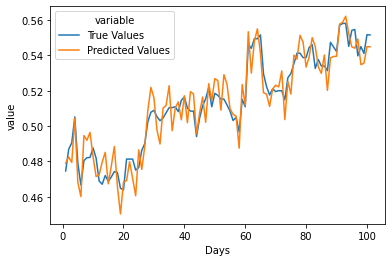

In [272]:
import seaborn as sns

def draw(y_actual, y_pred):
    num_rows = 101
    y_actual=y_actual.reshape(-1)
    y_pred=y_pred.reshape(-1)
    data_preproc = pd.DataFrame({'Days':[x for x in range(1, 102)], 'True Values': y_actual, 'Predicted Values': y_pred})
        
    sns.lineplot(x='Days', y='value', hue='variable', data=pd.melt(data_preproc, ['Days']))
def predict_graph(loader, scaler, model):
  for i, (x_batch, news_batch, y_batch, x_next) in enumerate(loader):
    index=60
    x=x_batch[index].unsqueeze(0)
    news=news_batch[index].unsqueeze(0)
    y_predicted_list = []
    y_new_pred = x_next[index].detach().cpu().numpy().reshape(-1)
    for k in range(100):
      y_pred=model(x, news)
      y_new_pre = y_pred.detach().cpu().numpy()
      y = y_new_pred[k]+predicted_list[k]
      y_predicted_list.append(y)
      x=x.detach().cpu().numpy()
      x=np.append(x, 1)
      x=x.reshape(1, -1)
      x=scaler.transform(x)
      x = x.reshape(-1, 1)
      x = x[:-1]
      x = np.append(x, y)
      x = x.reshape(1, -1)
      x=scaler.transform(x)
      x = x.reshape(-1, 1)
      x=x[1:]
      x=torch.tensor(x, dtype=torch.float32)
      x=x.unsqueeze(0)
      x=x.to(device)
    y_new_pred=np.append(y_new_pred, y_new_pred[-1])
    y_predicted_list.append(y_predicted_list[-1])
    draw(scaler.transform(y_new_pred.reshape(1, -1)), scaler.transform(np.array(y_predicted_list).reshape(1, -1))) 
    break
  
predict_graph(test_loader, scaler, modelTimeSeriesLSTM)

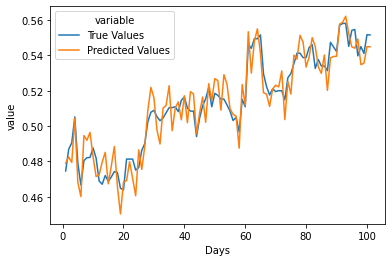

In [271]:
predict_graph(test_loader, scaler, modelTimeSeriesGRU)